In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from torch.nn import Sequential, ReLU, Linear, Conv1d, LSTM, RNN, Dropout
from torch.nn import Module
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor   
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

from NCP.model import DeepSVD
from NCP.layers import SingularLayer, MLPOperator

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": False,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)  

np.random.seed(0)
torch.manual_seed(0)
Ntrain = 50000
Nval = 1000
Ntest = 1000

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

symatrised pareto distribution

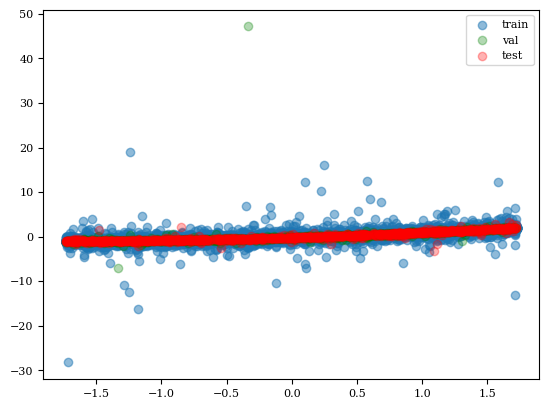

In [10]:
X = np.random.uniform(0.2, 5, Ntrain+Nval+Ntest)
Y = np.zeros(X.shape[0])
for i, xi in enumerate(X):
    Y[i] = xi**2 + np.random.pareto(2)*(np.random.binomial(1, 0.5, 1)-0.5)*2

X = X.reshape((-1, 1))
Y = Y.reshape((-1, 1))

xscaler = StandardScaler()
yscaler = StandardScaler()
# Xtransformed = X - X.mean()
# Ytransformed = Y - Y.mean()

Xtransformed = xscaler.fit_transform(X)
Ytransformed = yscaler.fit_transform(Y)

X_train, X_test, Y_train, Y_test = train_test_split(Xtransformed, Ytransformed, test_size=Ntest, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=Nval, random_state=0)

plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

epoch = 9999, loss = -6.113114833831787: 100%|██████████| 10000/10000 [03:44<00:00, 44.60it/s]


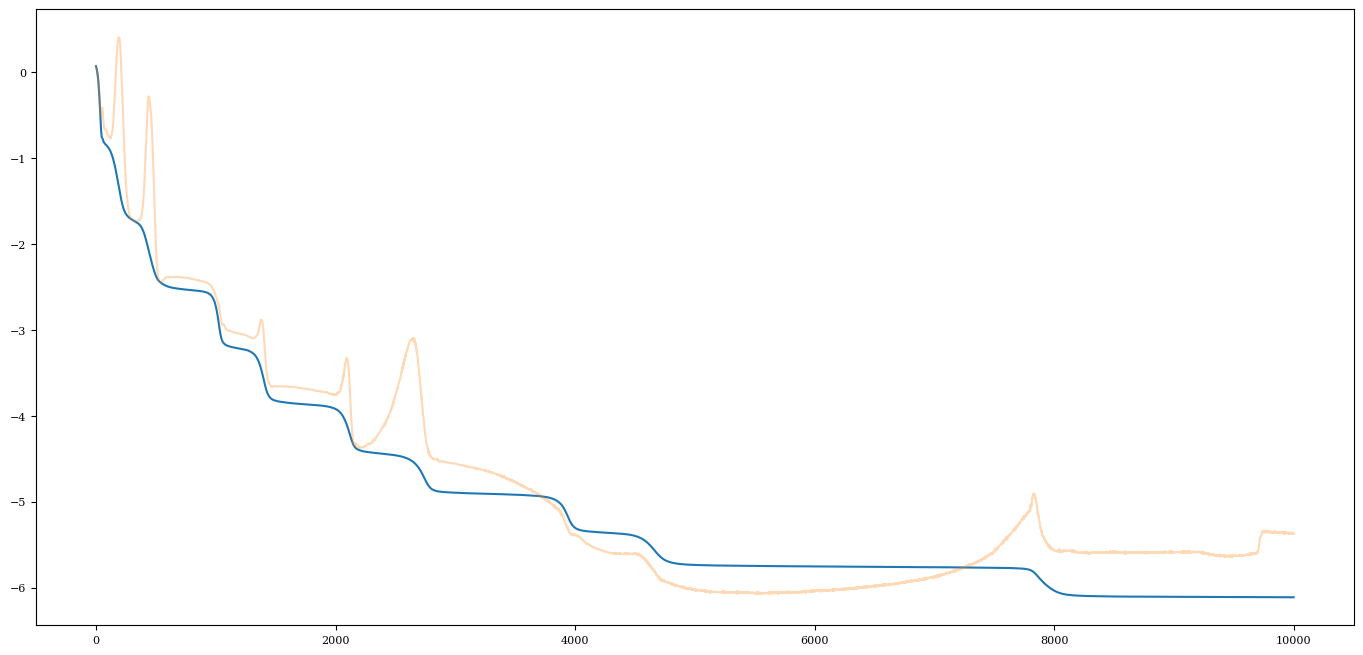

In [11]:
np.random.seed(0)
torch.manual_seed(0)

input_shape = X_train.shape[-1]
output_shape = 10
n_hidden = 2
layer_size = [16,16] # layer size of hidden layers.

U_operator = MLPOperator(input_shape, n_hidden, layer_size, output_shape)
V_operator = MLPOperator(input_shape, n_hidden, layer_size, output_shape)

optimizer = Adam
optimizer_kwargs = {
    'lr': 1e-3
    }
reg = (DeepSVD(U_operator, V_operator, output_shape, gamma=0.01))

reg.fit(X_train, Y_train, X_val, Y_val, epochs=int(1e4), optimizer=optimizer, optimizer_kwargs=optimizer_kwargs)

ls = reg.get_losses()
plt.figure(figsize=(17, 8))
plt.plot(range(len(ls)), np.array(ls))
plt.plot(range(len(ls)), np.array(reg.get_val_losses()), alpha=0.3)
# plt.yscale('log')
plt.show()

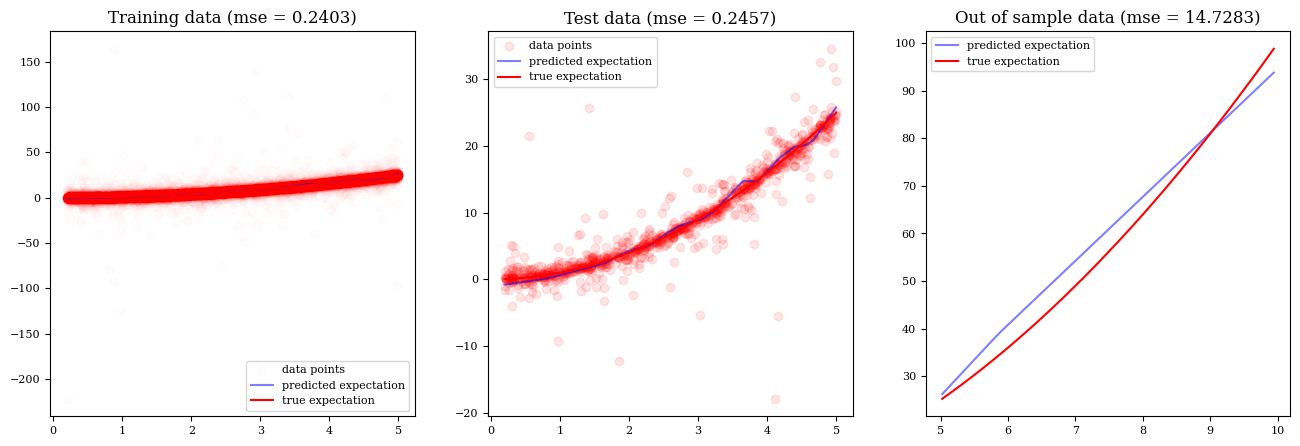

In [12]:
postprocess = 'centering'

pred = reg.predict(X_train, postprocess=postprocess).reshape(-1, 1)
pred_test = reg.predict(X_test, postprocess=postprocess).reshape(-1, 1)

X_out_of_sample = xscaler.transform(np.random.uniform(5,10, size=100).reshape(-1,1))
pred_oos = reg.predict(X_out_of_sample, postprocess=postprocess).reshape(-1, 1)

fig, axs = plt.subplots(ncols=3, figsize=(16, 5))
axes = axs.flatten()

Xs = xscaler.inverse_transform(X_train)
sorted = np.argsort(Xs.flatten())
axes[0].scatter(Xs, 
                yscaler.inverse_transform(Y_train), 
                color='r', alpha=0.01)
axes[0].plot(Xs.flatten()[sorted], 
             yscaler.inverse_transform(pred).flatten()[sorted], 'b', alpha=0.5)
axes[0].plot(Xs.flatten()[sorted], Xs.flatten()[sorted]**2, 'red')
axes[0].legend(['data points', 'predicted expectation', 'true expectation'])
axes[0].set_title(f'Training data (mse = {round(mean_squared_error(Xs**2, yscaler.inverse_transform(pred)), 4)})')

Xs = xscaler.inverse_transform(X_test)
sorted = np.argsort(Xs.flatten())
axes[1].scatter(Xs, 
                yscaler.inverse_transform(Y_test), 
                color='r', alpha=0.1)
axes[1].plot(Xs.flatten()[sorted], 
             yscaler.inverse_transform(pred_test).flatten()[sorted], 'b', alpha=0.5)
axes[1].plot(Xs.flatten()[sorted], Xs.flatten()[sorted]**2, 'red')
axes[1].legend(['data points', 'predicted expectation', 'true expectation'])
axes[1].set_title(f'Test data (mse = {round(mean_squared_error(Xs**2, yscaler.inverse_transform(pred_test)), 4)})')

Xs = xscaler.inverse_transform(X_out_of_sample)
sorted = np.argsort(Xs.flatten())
axes[2].plot(Xs.flatten()[sorted], 
             yscaler.inverse_transform(pred_oos).flatten()[sorted], 'b', alpha=0.5)
axes[2].plot(Xs.flatten()[sorted], Xs.flatten()[sorted]**2, 'red')
axes[2].legend(['predicted expectation', 'true expectation'])
axes[2].set_title(f'Out of sample data (mse = {round(mean_squared_error(Xs**2, yscaler.inverse_transform(pred_oos)), 4)})')

plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2)
axes = ax.flatten()

for i, xi in enumerate([0, 1, 3+p*(x_max-x_min)/2, 5]):

    x_scaled = torch.Tensor(xscaler.transform([[xi]]))
    fys, cdf_pred = get_cdf(reg, x_scaled, postprocess='whitening')
    cdf_pred = smooth_cdf(fys, cdf_pred)
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()

    true_cdf = norm.cdf(fys, loc=xi**2, scale=1+np.abs(xi))

    # normalising the plots for readability:
    if xi <= 5:
        loc = xi**2
        scale = np.sqrt(1+np.abs(xi))
        plt_interv = [loc - 5*scale, loc+5*scale]

        good_fys = ((plt_interv[0] <= fys) & (fys <= plt_interv[1]))

        fys = fys[good_fys]
        cdf_unscaled = cdf_unscaled[good_fys]
        true_cdf = true_cdf[good_fys]

    axes[i].plot(fys, cdf_pred)
    axes[i].plot(fys, true_cdf)
    print('result for x=', i)
    print(f'- KL: {kullback_leibler(cdf_pred, true_cdf, fys, plt_interv)}')
    print(f'- Hellinger: {hellinger(cdf_pred, true_cdf)}')
    print(f'- Wasserstein: {wasserstein1(cdf_pred, true_cdf)}')

plt.show()